<a href="https://colab.research.google.com/github/davidhilpert/tiny_mann/blob/main/tiny_mann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tiny Mann

- type: stateful RNN (experimental)
- description: character level RNN to predict next letter based on Heinrich Mann's "Der Untertan"
- source: https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb

In [ ]:
!pip install unidecode
import unidecode
import string
import random
import re
import torch
import torch.nn as nn
from torch.autograd import Variable

from tensorflow import keras

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.2 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# load data
file_path = '/content/drive/MyDrive/tiny_mann/h_mann_untertan.txt'

with open(file_path, 'r') as file:
    file = file.read()

file_len = len(file)
print('file_len =', file_len, 'characters')
print(file[0:300])


file_len = 847692 characters
                                    I.


Diederich Heßling war ein weiches Kind, das am liebsten träumte, sich vor
allem fürchtete und viel an den Ohren litt. Ungern verließ er im Winter
die warme Stube, im Sommer den engen Garten, der nach den Lumpen der
Papierfabrik roch und über dessen Goldregen-


In [ ]:
# "character space" of all possible characters
all_characters = set(file)
n_characters = len(all_characters)
print(n_characters)
print(all_characters)


83
{'y', 'g', 'U', 'f', ';', 'i', 'k', 'd', '"', 'A', 'h', 'e', '2', 'v', 'F', '3', 'J', 'c', 'O', 'l', 'K', '&', ' ', 'E', 'G', ':', 'ß', '6', '7', 'j', '8', 'q', 'ü', 'M', '-', '0', '9', '(', 'Q', 't', 'Ä', 'z', 'D', 'x', '!', 'o', 'w', '4', 'C', 'S', 'V', 'r', 'T', 'u', 'N', 'B', 'Z', 'H', 'n', 'L', ')', 'ö', '1', 'Ö', 's', 'b', "'", '5', 'é', ',', '?', 'P', '.', 'I', 'a', 'W', 'ä', 'p', '_', 'R', '\n', 'm', 'Ü'}


In [ ]:
# turn each chunk (string) into a LongTensor (used for integer values) (list of longs),
# by looping through the characters of the string and looking up the index of each character in all_characters.

# convert the set to a sorted list
all_characters_list = sorted(list(all_characters))

# Optional: Create a mapping from character to index
char_to_index = {char: idx for idx, char in enumerate(all_characters_list)}

# Step 3: Define the function to convert characters to tensor
def chars_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = char_to_index[string[c]]  # Use the char_to_index mapping
    return Variable(tensor)

# Test the function
print(chars_to_tensor('abcDEF'))

tensor([49, 50, 51, 27, 28, 29])


In [ ]:
from torch.utils.data import Dataset, DataLoader

# function/class to
class ShakespeareDataset(Dataset):
    def __init__(self, text, chunk_len=200):
      # assign parameters
        self.text = text
        self.chunk_len = chunk_len

    def __len__(self):
      # define length method
        return len(self.text) // self.chunk_len

    def __getitem__(self, idx):
      # learn how to splice data
        start = idx * self.chunk_len
        end = start + self.chunk_len + 1
        chunk = self.text[start:end]
        inp = chars_to_tensor(chunk[:-1])
        target = chars_to_tensor(chunk[1:])
        return inp, target


In [ ]:
# indexing: ensure equally-sized batches of 32 sequences (file_len // (32*200) # 174.2803125 batches)
chunk_len = 200 # junks of n characters
dataset = ShakespeareDataset(file[:(132 * 32*chunk_len +1)]) # + 1 such that last sequence is of length 200, too
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
# model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size # aka sequence_length
        self.hidden_size = hidden_size
        self.output_size = output_size # aka sequence_length
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size) # linear layer that encodes the input character into an internal state,
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=0.3) # LSTM layer (which may itself have multiple layers) that operates on that internal state and a hidden state,
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size) # decoder layer that outputs the probability distribution.

    def forward(self, input, hidden):
        # input shape: (batch_size, seq_len),
        # hidden shape: (n_layers, batch_size, hidden_size)
        embedded = self.encoder(input).unsqueeze(0)  # (1, batch_size, hidden_size)
        output, hidden = self.lstm(embedded, hidden)  # output: (1, batch_size, hidden_size), hidden: (n_layers, batch_size, hidden_size)
        output = self.layer_norm(output)
        output = self.decoder(output.squeeze(0))  # output: (batch_size, output_size)
        return output, hidden

    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).to(device),
                Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).to(device)) # for LSTM, hidden state is a tuple (hidden, cell state)


In [ ]:
# evaluation
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
  with torch.no_grad(): # avoid tracking gradients during evaluation:
    batch_size = 1  # Since we're evaluating a single sequence
    hidden = decoder.init_hidden(batch_size)
    prime_input = chars_to_tensor(prime_str).to(device)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1): # loop over length of priming string
        _, hidden = decoder(prime_input[p].unsqueeze(0), hidden) # Add batch dimension (unsqueeze to 1x1)
    inp = prime_input[-1].unsqueeze(0) # Also unsqueeze here to match batch dimension

    for p in range(predict_len): # loop over length of to-be-predicted string
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters_list[top_i]
        predicted += predicted_char
        inp = chars_to_tensor(predicted_char).to(device)

    return predicted



In [ ]:

def train_batch(inp, target, hidden):
    batch_size = inp.size(0) # "default" case: 32
    decoder.zero_grad()
    loss = 0

    inp, target = inp.to(device), target.to(device)  # Move input and target to GPU

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden) # Feed batch of characters at each time step c
        # Calculate (batch) loss
        loss += criterion(output, target[:, c])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len, hidden # replaced loss.data[0] w. loss.data




In [ ]:
# track time
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
# define training parameters, instantiate model:
n_epochs = 200 # 100 # down from 2000
batch_size = 32
print_every = 100
plot_every = 10
hidden_size = 512 # 200 # default: 100
n_layers = 3
lr = 0.0005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers).to(device) # input_size, hidden_size, output_size, num_layers
decoder_optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() # takes unnormalized logits for each class (input), class indices (target)


In [ ]:
# start training
start = time.time()
avg_loss_per_epoch = []
loss_cum = 0

# initialize hidden state once at the start of the entire training process
hidden = decoder.init_hidden(batch_size)

for epoch in range(1, n_epochs + 1):
  print("Start epoch ", epoch)
  for inp, target in dataloader: # in for i, payload in enumerate(dataloader): payload[0] is input, payload[1] is target (each 32x200)
    loss, hidden = train_batch(inp, target, hidden) # pass hidden state between batches
    hidden = tuple(h.detach() for h in hidden)  # Detach hidden after each batch (inserted after eliminating detaching hidden states after every it above)
    loss_cum += loss

  # Reset hidden state at the end of each epoch if necessary, or between different sequences
  hidden = tuple(h.detach() for h in hidden)  # Detach the hidden state for the next epoch

  # after each epoch
  print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
  print(evaluate('A', 100, temperature = 1.3), '\n')
  print(evaluate('A', 100, temperature = 0.8), '\n')
  print(evaluate('A', 100, temperature = 0.5), '\n')

  avg_loss_per_epoch.append(loss_cum / len(dataloader))
  loss_cum = 0


Start epoch  1
 6s (1 0%) 1.9010]
Art des
Güngesertänter
j zist, eitte dFÄst tetlänxen wllsoc
konnt. Suchs,
bist gwür
grhote. Ur verbst 

Ars, am deu Schneufer auf und sie velleitzreite
werhen, estenklich, war kanden
auf seanze der Gedes f 

Anden die sie und der er so die Felligen durch sich auf der Wasten die Gerischen Herrennen der Buck d 

Start epoch  2
 10s (2 1%) 1.7303]
Augte s unNam Walt, )robarhe JadajossamGte. "Der
Rach nichj
striale, verschreke
nun unauonk
schfäd' M 

Agen horzeilige Geisterliche
Zasmili der dem Mittlückerritet der Freinde Gedens aber der Straf auf de 

Alte
Diederich sich und der den Gefühlen, vor der er der Vater gestreckte der Ansträden, daß er seine 

Start epoch  3
 12s (3 1%) 1.6400]
Akeil, dmn
der Didst, wer, ja, wieder, unsoch Verbrezugung. Zeit Gust es
Sichte. Die Schrckwegonen Ti 

Angebei nichts und seine Agnes ab. Er auf der Scchwejer beschreit und wilkt zu beschlassen, die Ausso 

Agen, der er schritte er hat den Aufstrecken, die der sein Man s

In [ ]:
model_save_path = '/content/drive/MyDrive/tiny_mann/decoder_weights_v02.pth'
# Save the model's state dictionary
torch.save(decoder.state_dict(), model_save_path)
print(f'Model weights saved to {model_save_path}')

Model weights saved to /content/drive/MyDrive/tiny_mann/decoder_weights_v02.pth


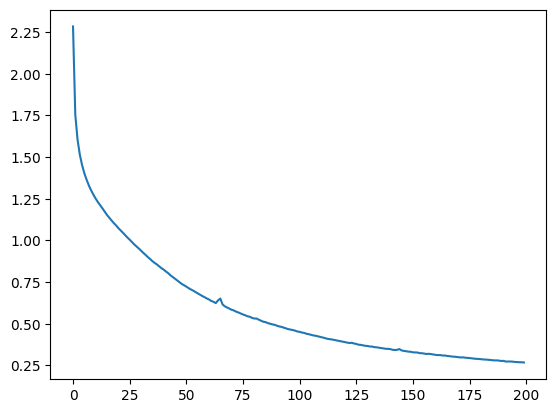

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(avg_loss_per_epoch)


# goal: loss <1

# Load saved model weights

In [ ]:
# load saved model weights

decoder = RNN(n_characters, hidden_size, n_characters, n_layers).to(device) # input_size, hidden_size, output_size, num_layers

# Load the state dictionary
model_save_path = '/content/drive/MyDrive/tiny_mann/decoder_weights_v02.pth'
decoder.load_state_dict(torch.load(model_save_path))
decoder.eval()  # Set to evaluation mode if you are using the model for inference

print(f'Model weights loaded from {model_save_path}')


Model weights loaded from /content/drive/MyDrive/tiny_mann/decoder_weights_v02.pth


<ipython-input-27-4475aa506758>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load(model_save_path))


In [ ]:
import torch.nn.functional as F

def predict_next_char_probabilities(input_str, temperature=0.8):
    with torch.no_grad():
        # Initialize hidden state
        batch_size = 1
        hidden = decoder.init_hidden(batch_size)
        input_tensor = chars_to_tensor(input_str).to(device)

        # Process input to build up hidden state
        for i in range(len(input_str) - 1):
            _, hidden = decoder(input_tensor[i].unsqueeze(0), hidden)

        # Get the last character as input for prediction
        last_char = input_tensor[-1].unsqueeze(0)
        output, hidden = decoder(last_char, hidden)

        # Calculate probabilities for the next character over the entire character set
        output_dist = F.softmax(output.view(-1) / temperature, dim=0)
        probabilities = output_dist.cpu().numpy()  # Convert to numpy array for easier handling

        return probabilities


In [ ]:
pred_mat = []
for character in all_characters_list:
  pred = predict_next_char_probabilities(character, temperature=1)
  pred_mat.append(pred)



In [ ]:
import numpy as np
import pandas as pd

pred_arr = np.array(pred_mat)
pred_df = pd.DataFrame(pred_arr)
pred_df.columns = all_characters_list
pred_df.index = all_characters_list

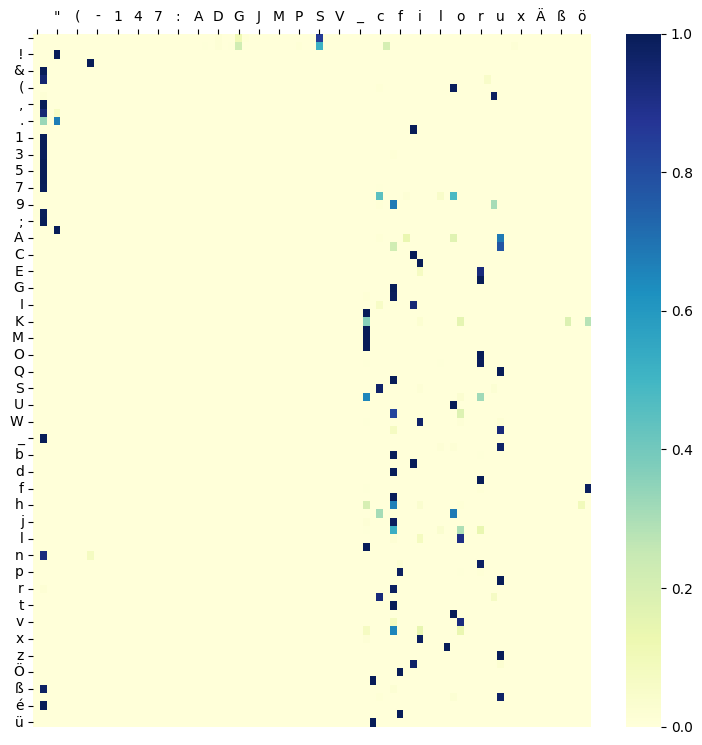

In [ ]:
import seaborn
from matplotlib import pyplot
pyplot.figure(figsize=(9, 9))
ax = seaborn.heatmap(pred_df, cmap="YlGnBu")
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
pyplot.show()